<h1 class="text_center">Project Description</h1><br>
Analytics work for taxi company, a new ride-sharing company that's launching in Chicago. Task is to find patterns in the available information. I want to understand passenger preferences and the impact of external factors on rides.
I'll study a database, analyze data from competitors, and test a hypothesis about the impact of weather on ride frequency.


<h3 class="text_center">Description of the data</h3>

A database with info on taxi rides in Chicago:<br>

<code class="code-inline_theme_light">neighborhoods</code> table: data on city neighborhoods<br>
    - name: name of the neighborhood<br>
    - neighborhood_id: neighborhood code<br>
<code class="code-inline_theme_light">cabs</code> table: data on taxis<br>
    - cab_id: vehicle code<br>
    - vehicle_id: the vehicle's technical ID<br>
    - company_name: the company that owns the vehicle<br>
<code class="code-inline_theme_light">trips</code> table: data on rides<br>
    - trip_id: ride code<br>
    - cab_id: code of the vehicle operating the ride<br>
    - start_ts: date and time of the beginning of the ride (time rounded to the hour)<br>
    - end_ts: date and time of the end of the ride (time rounded to the hour)<br>
    - duration_seconds: ride duration in seconds<br>
    - distance_miles: ride distance in miles<br>
    - pickup_location_id: pickup neighborhood code<br>
    - dropoff_location_id: dropoff neighborhood code<br>
<code class="code-inline_theme_light">weather_records</code> table: data on weather<br>
    - record_id: weather record code<br>
    - ts: record date and time (time rounded to the hour)<br>
    - temperature: temperature when the record was taken<br>
    - description: brief description of weather conditions, e.g. "light rain" or "scattered clouds"<br>


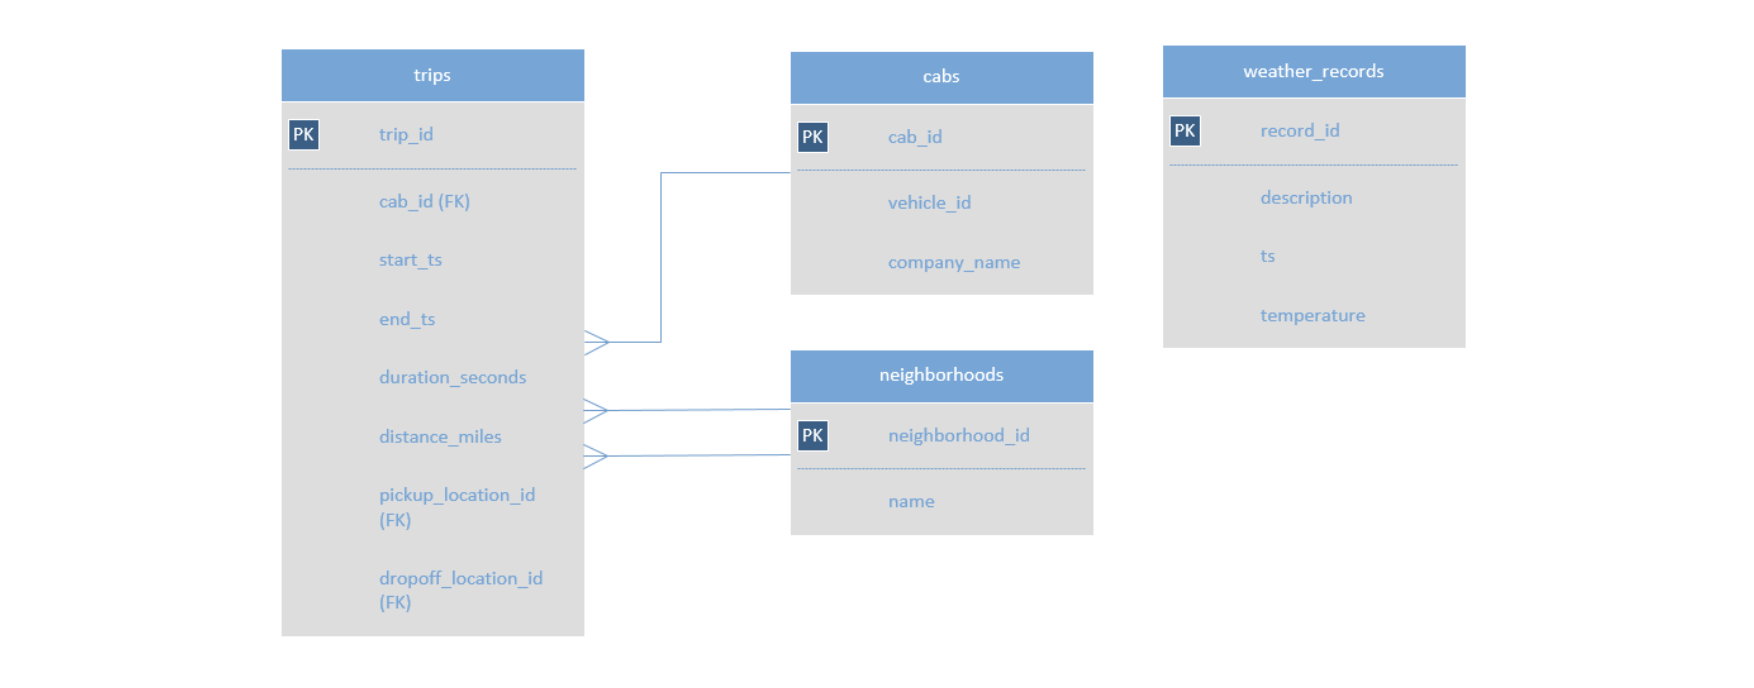

https://pastenow.ru/9NHWO

<h3 class="text_center">Parsing data</h3>

In [45]:
import pandas as pd
from scipy import stats as st

import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup


In [7]:
URL='https://code.s3.yandex.net/data-analyst-eng/chicago_weather_2017.html'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')
table = soup.find('table', attrs={"id": "weather_records"})
heading_table=[]

for row in table.find_all('th'):
    heading_table.append(row.text)
content=[]

for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])
        
weather_records = pd.DataFrame(content, columns = heading_table)

print(weather_records)


           Date and time Temperature       Description
0    2017-11-01 00:00:00     276.150     broken clouds
1    2017-11-01 01:00:00     275.700  scattered clouds
2    2017-11-01 02:00:00     275.610   overcast clouds
3    2017-11-01 03:00:00     275.350     broken clouds
4    2017-11-01 04:00:00     275.240     broken clouds
..                   ...         ...               ...
692  2017-11-29 20:00:00     281.340        few clouds
693  2017-11-29 21:00:00     281.690      sky is clear
694  2017-11-29 22:00:00     281.070        few clouds
695  2017-11-29 23:00:00     280.060      sky is clear
696  2017-11-30 00:00:00     278.460      sky is clear

[697 rows x 3 columns]


<h3 class="text_center">SQL queries</h3><br>

<div style="margin-top: 20px;">
    <h4>1).</h4>
    <code class="code-block">
SELECT
    start_ts,
    CASE
        WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
        ELSE 'Good'
    END AS weather_conditions,
    duration_seconds
FROM
    trips
INNER JOIN weather_records ON weather_records.ts = trips.start_ts
WHERE
    trips.pickup_location_id = 50 AND
    trips.dropoff_location_id = 63 AND
    EXTRACT(isodow FROM trips.start_ts) = 6
ORDER BY
    trips.start_ts;
    </code>
</div>


<div style="margin-top: 20px;">
    <h4>2).</h4>
    <code class="code-block">
SELECT
    subquery.company_name,
    COUNT(subquery.cab_id) AS trips_amount
FROM
    trips
LEFT JOIN
    (
    SELECT --select cab_id and company_name for 2019-11-15 and 2019-11-16
        cab_id,
        company_name
    FROM
        cabs
    ) AS subquery ON subquery.cab_id = trips.cab_id
WHERE
    CAST(trips.start_ts AS date) in
    ('2017-11-01',
     '2017-11-02',
     '2017-11-03',
     '2017-11-04',
     '2017-11-05',
     '2017-11-06',
     '2017-11-07') AND
     (subquery.company_name LIKE '%Yellow%' OR subquery.company_name LIKE '%Blue%')
GROUP BY
    subquery.company_name
ORDER BY
    trips_amount DESC;
    </code>
</div>


<div style="margin-top: 20px;">
    <h4>3).</h4>
    <code class="code-block">
SELECT
    CASE
        WHEN cabs.company_name NOT IN ('Flash Cab', 'Taxi Affiliation Services') THEN 'Other'
        ELSE cabs.company_name
    END AS company,
    COUNT(trips.trip_id) AS trips_amount  
FROM
    trips
LEFT JOIN cabs ON cabs.cab_id = trips.cab_id
WHERE
    CAST(trips.start_ts AS date) >= '2017-11-01' AND
    CAST(trips.start_ts AS date) < '2017-11-08'
GROUP BY
    company
ORDER BY
    trips_amount DESC;
    </code>
</div>


<div style="margin-top: 20px;">
    <h4>4).</h4>
    <code class="code-block">
SELECT
    SUBQ.dropoff_location_name AS dropoff_location_name,
    AVG(SUBQ.average_trips) AS average_trips
FROM
    (SELECT
        EXTRACT(day from trips.end_ts) AS day,
        COUNT(trips.trip_id) AS average_trips,
        neighborhoods.name AS dropoff_location_name
    FROM
        trips
    INNER JOIN neighborhoods ON neighborhoods.neighborhood_id = trips.dropoff_location_id
    GROUP BY
         day,
         dropoff_location_name) AS SUBQ
GROUP BY
    dropoff_location_name
ORDER BY
    average_trips DESC;
    </code>
</div>


<div style="margin-top: 20px;">
    <h4>5).</h4>
    <code class="code-block">
SELECT
    neighborhood_id,
    name
FROM
    neighborhoods
GROUP BY
    neighborhood_id,
    name
HAVING
    name LIKE '%Hare' OR name LIKE 'Loop'
    </code>
</div>


<div style="margin-top: 20px;">
    <h4>6).</h4>
    <code class="code-block">
SELECT
    ts,
    case
        when description like '%rain%' or description like '%storm%' then 'Bad'
        else 'Good'
    end as weather_conditions
FROM
    weather_records
    </code>
</div>


<div style="margin-top: 20px;">
    <h4>7).</h4>
    <code class="code-block">
SELECT
    start_ts,
    CASE
        WHEN description LIKE '%rain%' OR description LIKE '%storm%' THEN 'Bad'
        ELSE 'Good'
    END AS weather_conditions,
    duration_seconds
FROM
    trips
INNER JOIN weather_records ON weather_records.ts = trips.start_ts
WHERE
    trips.pickup_location_id = 50 AND
    trips.dropoff_location_id = 63 AND
    EXTRACT(isodow FROM trips.start_ts) = 6
ORDER BY
    trips.start_ts;
    </code>
</div>


<h1 class="text_center">Exploratory data analysis</h3>

In [9]:
dropoff_average = pd.read_csv("./project_sql_result_04.csv")
dropoff_average.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
dropoff_location_name    94 non-null object
average_trips            94 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB


In [11]:
dropoff_average['average_trips'] = dropoff_average['average_trips'].astype(int)
dropoff_average.head(20)


,dropoff_location_name,average_trips
0,Loop,10727
1,River North,9523
2,Streeterville,6664
3,West Loop,5163
4,O'Hare,2546
5,Lake View,2420
6,Grant Park,2068
7,Museum Campus,1510
8,Gold Coast,1364
9,Sheffield & DePaul,1259


<ul style="padding: 10px; padding-left: 30px;">
    <li>company_name: taxi company name</li>
    <li>trips_amount: the number of rides for each taxi company on November 15-16, 2017.</li>
<ul>

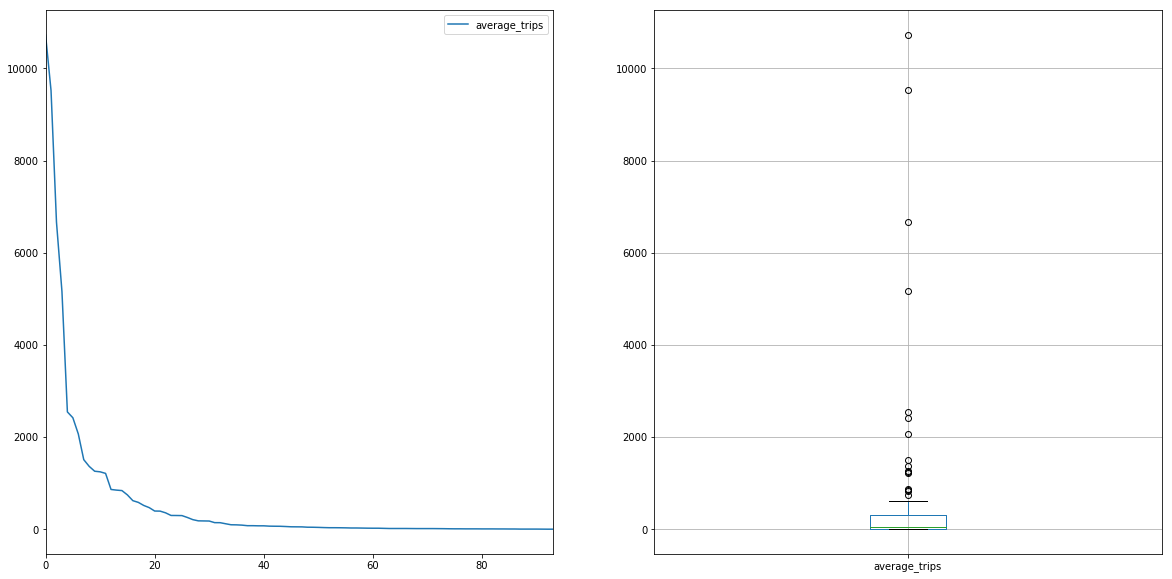

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
dropoff_average.plot(ax = ax[0])
dropoff_average.boxplot(ax = ax[1])


In [13]:
dropoff_average.describe()


,average_trips
count,94.000000
mean,599.478723
std,1714.555974
min,1.000000
25%,14.000000
50%,51.500000
75%,298.750000
max,10727.000000


<div style="padding: 10px">
    As you can see from the graphs above, the FIRST few observations (in this case, the drop-off points) have a large number of drop-offs on a par with the rest, which are distributed with approximately the same number.<br>
    
You can pay attention to the first graph and see that it is a parabola - which tells us that the first few observations have a large number of landings, and the rest are equally small.<br>

You can also pay attention to describe 75%, which tells us that 75% of observations have a maximum value of 300.<br>

Which tells us that most passengers disembark at these first 10-15 locations in Chicago.
</div>

In [15]:
company = pd.read_csv("./project_sql_result_01.csv")
company.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
company_name    64 non-null object
trips_amount    64 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [16]:
company.head(20)


,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


<ul style="padding: 10px 10px 10px 30px;">
    <li>dropoff_location_name: Chicago neighborhoods where rides ended</li>
    <li>average_trips: the average number of rides that ended in each neighborhood in November 2017.</li>
<ul>

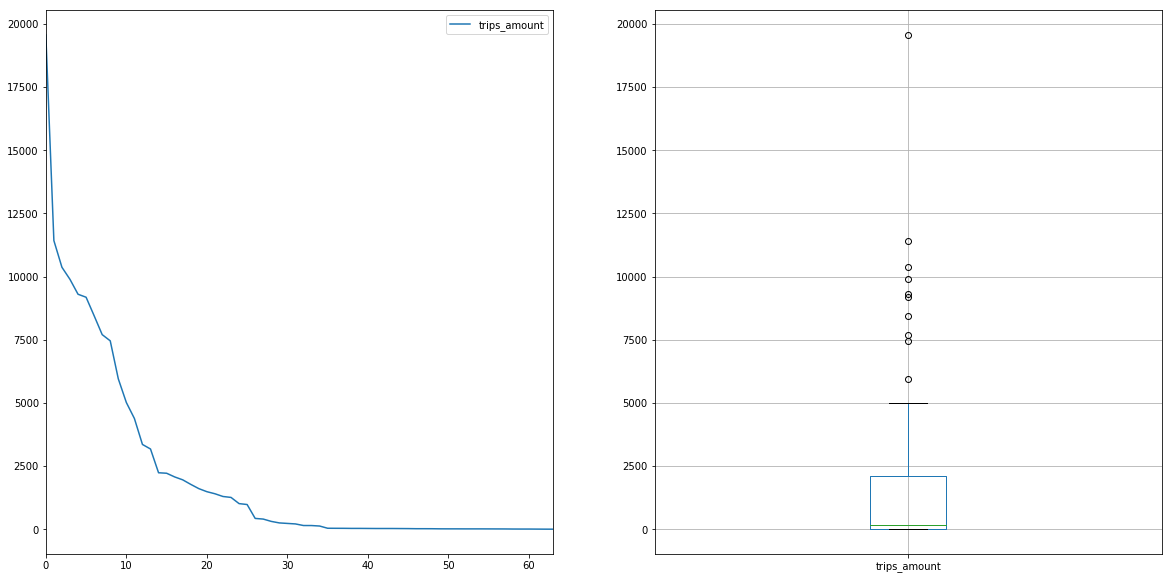

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
company.plot(ax = ax[0])
company.boxplot(ax = ax[1])

In [18]:
company.describe()

,trips_amount
count,64.000000
mean,2145.484375
std,3812.310186
min,2.000000
25%,20.750000
50%,178.500000
75%,2106.500000
max,19558.000000


<div style="padding: 10px">
    On the second charts, you can draw a similar conclusion and pay attention to the same points to make it.

Most passengers use the services of the first 20-25 taxi companies in Chicago.
</div>

<h3 class="text_center">Testing hypotheses </h3>

In [23]:
weather_time_start = pd.read_csv("./project_sql_result_07.csv")
weather_time_start.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
start_ts              1068 non-null object
weather_conditions    1068 non-null object
duration_seconds      1068 non-null float64
dtypes: float64(1), object(2)
memory usage: 25.2+ KB


In [24]:
weather_time_start

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1063,2017-11-25 11:00:00,Good,0.0
1064,2017-11-11 10:00:00,Good,1318.0
1065,2017-11-11 13:00:00,Good,2100.0
1066,2017-11-11 08:00:00,Good,1380.0


<div>
    <p>It contains data on rides from the Loop to O'Hare International Airport. Remember, these are the table's field values:
    </p>
    <ul>
        <li>start_ts: pickup date and time</li>
        <li>weather_conditions: weather conditions at the moment the ride started</li>
        <li>duration_seconds: ride duration in seconds</li>
    </ul><br>
    <p>We see that seconds are stored in the float data type - we need to translate them to int. The date is also stored as a string - let's convert it to a DateType so that it is convenient to work with.
    </p>
    <p>Also let's check for duplicates.
    </p>
</div>

In [41]:
weather_time_start['start_ts'] = pd.to_datetime(weather_time_start['start_ts'], format='%Y-%m-%d %H:%M:%S') 
weather_time_start['duration_seconds'] = weather_time_start['duration_seconds'].astype(int)

print('weather_time_start duplicates =', weather_time_start.duplicated().sum())


weather_time_start = weather_time_start.drop_duplicates(keep=False)

print('weather_time_start duplicates =', weather_time_start.duplicated().sum())


weather_time_start duplicates = 0
weather_time_start duplicates = 0


In [42]:
weather_time_start.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 750 entries, 0 to 1067
Data columns (total 4 columns):
start_ts              750 non-null datetime64[ns]
weather_conditions    750 non-null object
duration_seconds      750 non-null int64
weekday               750 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 29.3+ KB


<div>
    Let's check if we have trips equal to 0 seconds, if there are any, they should be deleted from the Data Frame
</div>

In [29]:
weather_time_start['duration_seconds'].value_counts().sort_index()

0       6
60      1
420     1
480     2
1018    1
       ..
4380    1
4800    1
4980    2
6420    1
7440    1
Name: duration_seconds, Length: 490, dtype: int64

In [43]:
weather_time_start = weather_time_start[weather_time_start['duration_seconds'] != 0]
weather_time_start

,start_ts,weather_conditions,duration_seconds,weekday
0,2017-11-25 16:00:00,Good,2410,5
1,2017-11-25 14:00:00,Good,1920,5
2,2017-11-25 12:00:00,Good,1543,5
3,2017-11-04 10:00:00,Good,2512,5
5,2017-11-11 04:00:00,Good,1320,5
...,...,...,...,...
1059,2017-11-11 10:00:00,Good,1303,5
1060,2017-11-04 14:00:00,Good,2700,5
1061,2017-11-18 16:00:00,Bad,2186,5
1064,2017-11-11 10:00:00,Good,1318,5


<div>
    Now that the data has been cleared and returned to normal state, add the days of the week column to DataFrame to test the hypothesis:<br>
    <span style="color: green; margin-left: 100px;">"The average duration of rides from the Loop to O'Hare International Airport changes on rainy Saturdays."</span>
</div>

In [44]:
weather_time_start['weekday'] = weather_time_start['start_ts'].dt.dayofweek
weather_time_start['weekday'].value_counts()

5    750
Name: weekday, dtype: int64

<div>
    I forgot that we were at the last step and so took the information only on Saturdays :) We will continue further.
</div>

In [36]:
good_weather_data = weather_time_start[weather_time_start['weather_conditions'] == 'Good']['duration_seconds']
bad_weather_data = weather_time_start[weather_time_start['weather_conditions'] != 'Good']['duration_seconds']


<div>
    We set the parameter equal_var=true, because we take data from a single sample and assume that the variances are equal, so that our p-value probability is more accurate.<br>

We use st.test_ind to test our hypothesis in order to compare the average values of two statistical aggregates based on samples.<br>
    
We compare the travel time in good and bad weather, and first of all we want to check whether they are equal. Run a test.
    
</div>

In [37]:
alpha = .05

results = st.ttest_ind(
        bad_weather_data, 
        good_weather_data)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  1.8265509279963003e-06
We reject the null hypothesis


<div>
    p-value is very small, which tells us about the difference in values. Now we will conduct a second test with the null hypothesis: on a day with bad weather, the travel time is longer than on a day with good weather.
</div>

In [38]:
bad_weather_data.mean()


2415.6746031746034

In [39]:
good_weather_data.mean()


2059.048076923077

In [40]:
interested_value = good_weather_data.mean()

alpha = .05 # critical statistical significance

results = st.ttest_1samp(
        bad_weather_data, 
        interested_value)

print('p-value: ', results.pvalue / 2)

if (results.pvalue / 2 < alpha) and (bad_weather_data.mean() > interested_value):
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

p-value:  4.943706352646099e-07
We reject the null hypothesis


<div>
    The observed value is more than the one predicted. The difference between the values is statistically significant (we divide the p-value we got from the two-sided test by 2).
</div>

<h3 style="text-align: center">Mini conclusion</h3>

<div>
    Driving time on a Sunny day is shorter, as it is easier for the driver and traffic is generally easier.
</div>